# Atividade 3 — *Ensembles* e avaliação

O objetivo desta atividade é fazer uma comparação entre diferentes métodos de classificação a fim de desenvolver todo o ***pipeline*** do processo: pré-processamento, definição de hiperâmetros, treino, avaliação e comparação dos métodos.

Você investigará o comportamento dos seguintes **quatro** métodos, dentre os quais, dois são métodos de combinação de preditores.


*  SVM
*  Árvore de Decisão
*  Florestas Aleatórias
*  Gradient Boosting




Vamos iniciar importando as bibliotecas e a base de dados que será utilizada.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer

from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Parte 1

### Carregando os dados

Neste exemplo, será utilizada a base **Breast Cancer**, a qual está disponível no sklearn mas é originária do repositório da UCI (https://archive.ics.uci.edu/ml/datasets/breast+cancer). Trata-se de uma base de dados que foi obtida a partir de imagens digitalizadas de massas mamárias e que descrevem **dois** tipos de classe: maligno (*harmful*) e benigno (not harmful). Os atributos descrevem características dos núcleos celulares presentes nas imagens.

No total, são **30 atributos** ordenados: raio médio, textura média, perímetro médio, área média, suavidade média, compacidade média, concavidade média, pontos côncavos médios, simetria média, dimensão fractal média, erro de raio, erro de textura, erro de perímetro, erro de área, erro de suavidade, erro de compactação, erro de concavidade, erro de pontos côncavos, erro de simetria, erro de dimensão fractal, pior raio, pior textura, pior perímetro, pior área, pior suavidade, pior compacidade, pior concavidade, piores pontos côncavos, pior simetria e pior dimensão fractal) e um alvo (tipo de tumor).

In [2]:
from sklearn import datasets

In [3]:
breast = load_breast_cancer()

Conteúdo do *bunch*:

In [4]:
 X = breast.data

In [5]:
y = breast.target

### Reamostragem com *hold-out*

Como será necessário fazer ajustes dos hiperparâmetros dos métodos de classificação investigados, você deverá dividir a base de dados em três conjuntos: treino, validação e teste. A base de treino terá 60% das instâncias, enquanto as bases de teste e de validação terão 20% cada.

> **Separe, com hold-out**, o conjunto de teste do restante dos dados. Deixe 20% para teste. Especifique a semente aleatória `42`.

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
     X, y, test_size=0.2, random_state=42
    )

Se feito corretamente, o teste deve ter 114 exemplos e o restante deverá ter 455 exemplos. Ambos deverão ter 30 atributos.

In [8]:
print(X_trainval.shape, y_trainval.shape)
print(X_test.shape, y_test.shape)

(455, 30) (455,)
(114, 30) (114,)


Agora vamos separar o conjunto de treino e o conjunto de validação. Para isso, faça uma nova divisão em hold-out, reservando 25% para o conjunto de validação (`test_size=0.25`).

> **Faça *hold-out*** para obter um conjunto de treino e um conjunto de validação.

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42
    )

O conjunto de validação deverá ter 114 instâncias e o conjunto de treino deverá ter 341 instâncias.

In [10]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(341, 30) (341,)
(114, 30) (114,)


### Normalização dos dados

Uma vez que os dados foram separados em subconjuntos, nós vamos fazer o pré-processamento. Um dos passos que necessitamos fazer é a normalização, pois os atributos estão em escalas muito distintas. Você pode observar a grande variação dos atributos nos diagramas de caixas a seguir.

> **Execute as células** abaixo para gerar os diagramas de caixas dos atributos da base *breast cancer*.

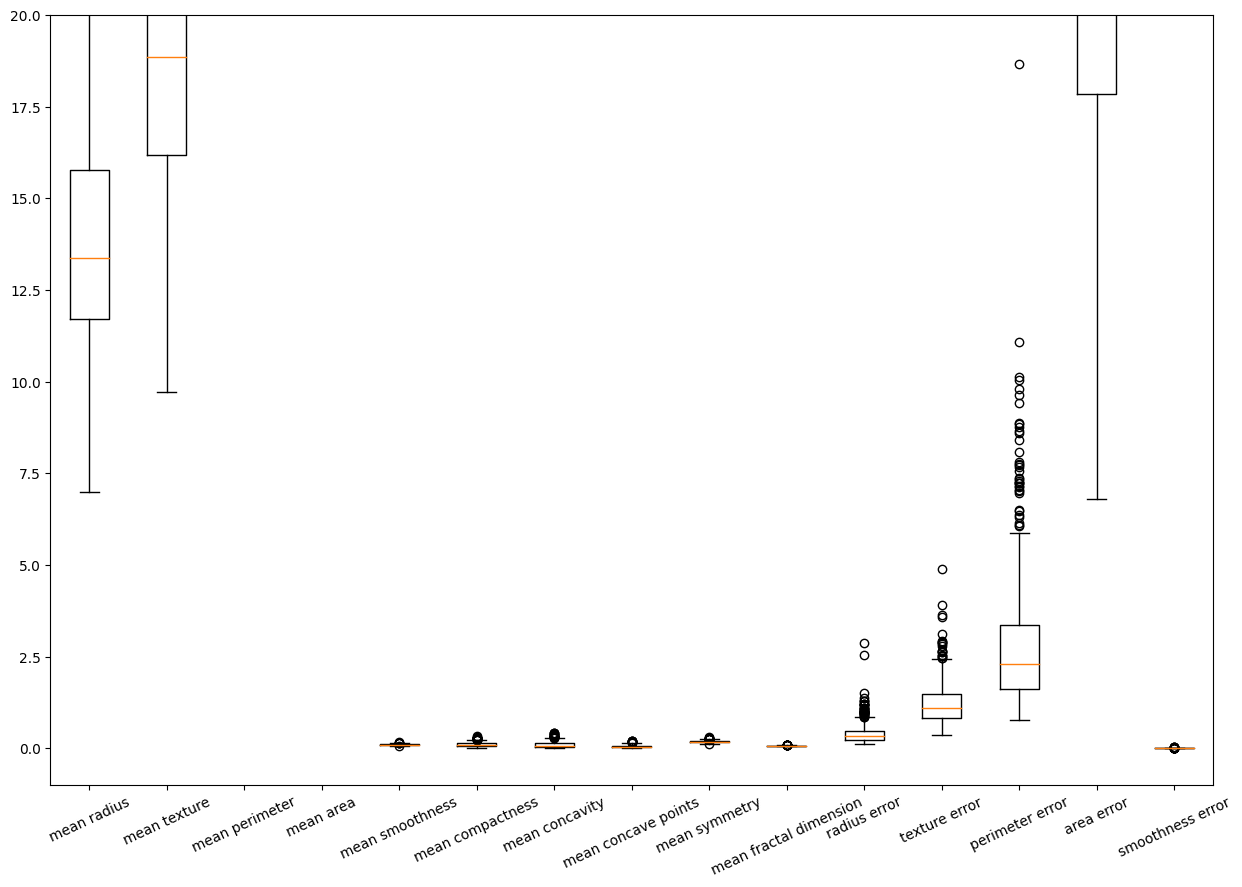

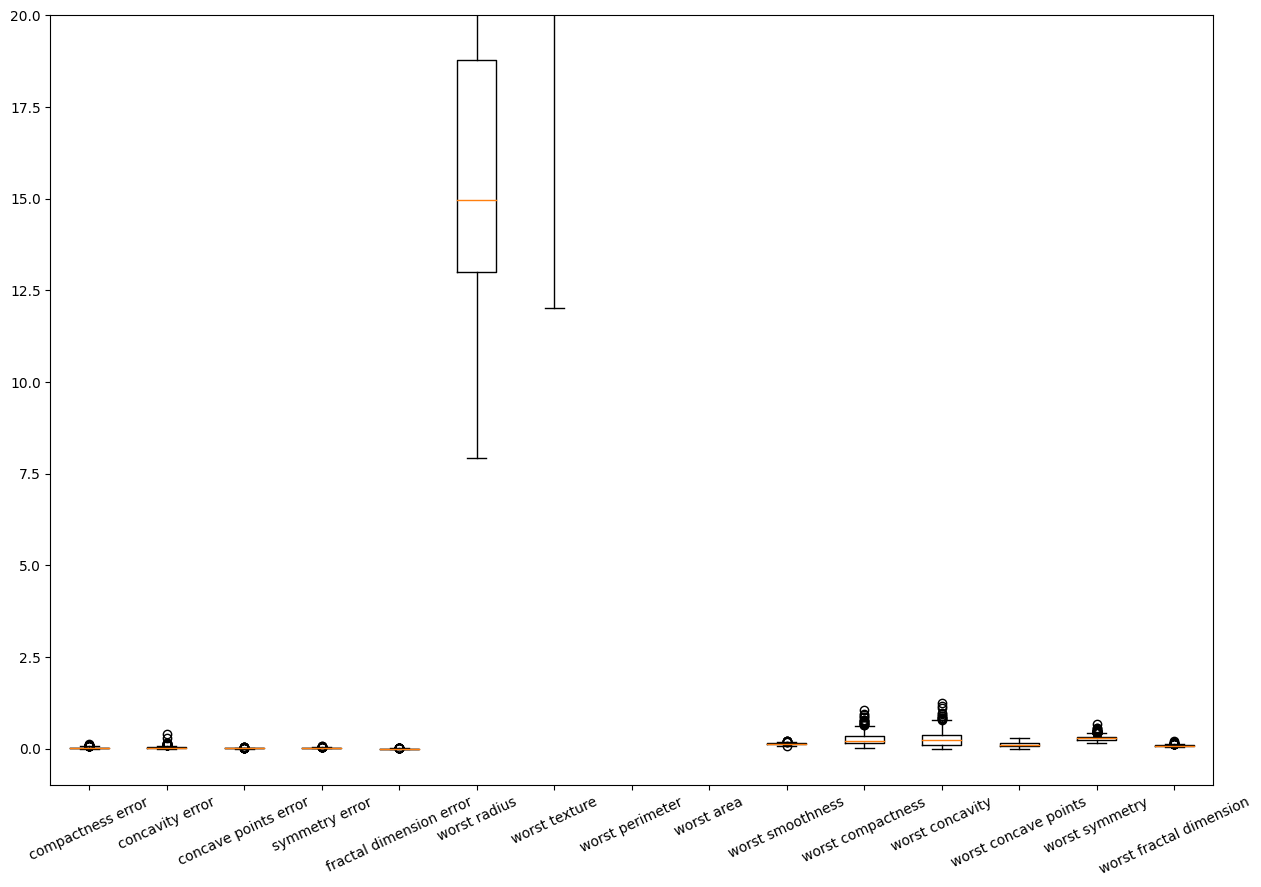

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10));
plt.boxplot(breast.data[:, :15], labels=breast.feature_names[:15]);
plt.xticks(rotation=25);
plt.ylim(-1, 20);

plt.figure(figsize=(15,10))
plt.boxplot(breast.data[:, 15:], labels=breast.feature_names[15:]);
plt.xticks(rotation=25);
plt.ylim(-1, 20);

Observe que a variação de alguns atributos é tão extrema que alguns diagramas nem mesmo aparecem na figura.

Como os atributos originais estão em diferentes escalas, você deverá normalizar os dados. Existem diferentes técnicas de normalização. Uma delas é a **normalização minmax**, vista na aula de técnicas de reamostragem. Ela é empregada para trazer todos os dados para uma escala definida por um limite inferior e um limite superior. Tipicamente esse limite é dado pelo intervalo $[0,1]$.

Um atributo $X$ pode ser trazido para o intervalo $[0,1]$ de acordo com o seguinte procedimento:

$$x' = \displaystyle\frac{x - x_\text{min}}{x_\text{max} - x_\text{min}}$$

Por exemplo, dada a seguinte coleção:

$$X = [3, 3, 3, 7, 10, 15, 17, 18]$$

Cada valor pode ser normalizado de acordo com a seguinte equação:

$$x' = \displaystyle\frac{x - 3}{18 - 3}$$

Uma outra estratégia de normalização é a **z-normalização**, na qual os dados são normalizados de acordo com a média e o desvio padrão de uma amostra. Após a z-normalização, a amostra terá média $m=0$ e desvio padrão amostral $s=1$.

Um atributo $X$ pode ser z-normalizado de acordo com o seguinte procedimento:

$$x' = \displaystyle\frac{x - m_x}{s_x}$$

Sendo que $m_x$ é a média do atributo $X$ e $s_x$ é o desvio padrão amostragem de $X$.

$$X =[3,3,3,7,10,12,13,17]$$

Cada valor pode ser normalizado de acordo com a seguinte equação:

$$x' = \displaystyle\frac{x - 8{,}5}{5}$$

Para obter z-normalização dos dados no `sklearn` você pode utilizar a classe `StandardScaler`. Ela possui um método `fit` que "aprende" os valores da distribuição (média e desvio padrão) e um método `transform` que aplica a transformação em uma matriz de atributos.

> **Faça z-normalização** dos conjuntos de treino, teste e validação. Selecione corretamente os conjuntos nos quais você deve aplicar `fit` e nos quais você deve aplicar `transform`.
>
> *Dica*: lembre-se da "história" do seu modelo. Em cada teste, quais serão os dados do presente e quais são os dados que simulam o futuro do modelo?

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### Avaliação do SVM

Nós utilizaremos inicialmente SVM. Embora nós não tenhamos muitas explicações sobre a distribuição dos dados, nós vamos utilizar SVM não linear. Neste exemplo, nós utilizaremos o **kernel polinomial** para exemplificar o processo de ajuste de hiperparâmetros.

Para avaliar o resultado nós observaremos a **matriz de confusão**, e o **relatório de métricas**.

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

Independentemente do tipo de kernel, SVM tem o hiperparâmetro C a ser definido. Além disso, no caso do kernel polinomial, há a necessidade de definição do grau do polinômio. Por fim, além do grau do polinômio, há o parâmetro gamma. Neste caso, nós deixaremos gamma com o valor padrão, o grau do polinômio como 2 e C=1.


> **Treine o SVM** com kernel polinomial de grau 2. Especifique hiperparâmetro `C=1`.

In [15]:
modelo_polinomial = SVC(kernel='poly', degree=2, C=1, gamma='scale', random_state=42)
modelo_polinomial.fit(X_train, y_train);

Agora vamos fazer a primeira inferência. Vamos testar o modelo no conjunto de treino e também no conjunto de validação. E vamos comparar as acurácias obtidas.

> **Teste o modelo** no conjuto de treino.

In [16]:
ypred_train = modelo_polinomial.predict(X_train)

> **Teste o modelo** no conjunto de validação.

In [17]:
ypred = modelo_polinomial.predict(X_val)

> **Execute a célula** abaixo para comparar as acurácias.

In [18]:
print("Acurácia no treino", accuracy_score(y_train, ypred_train))
print("Acurácia na validação", accuracy_score(y_val, ypred))

Acurácia no treino 0.8563049853372434
Acurácia na validação 0.8421052631578947


A acurácia dá uma visão geral sobre o desempenho do modelo, mas não nos permite tirar muitas conclusões. Isso é especialmente verdade em conjuntos desbalanceados (nosso conjunto não está *muito* desbalanceado, mas ainda assim há uma fração razoavelmente maior da classe positiva).

Uma visão um pouco mais abrangente pode ser obtida pela matriz de confusão. Ela tem a contagem das seguintes ocorrências:

               Previsão
              0         1
    Real. +--------+--------+
      0   |   VN   |   FP   |
          +--------+--------+
      1   |   FN   |   VP   |
          +--------+--------+
          
No `sklearn` a matriz pode ser obtida pela função `confusion_matrix`.

> **Execute a célula** abaixo para gerar a matriz de confusão dp modelo no conjunto de validação. Observe que o primeiro argumento deve ser o conjunto de rótulos verdadeiros.

In [19]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_val, ypred))

[[27 17]
 [ 1 69]]


Uma visão ainda mais detalhada do modelo pode ser obtida pela função `classification_report`.

> **Complete a célula** abaixo e use a função `classification_report`.

In [20]:
print(classification_report(y_val, ypred))

              precision    recall  f1-score   support

           0       0.96      0.61      0.75        44
           1       0.80      0.99      0.88        70

    accuracy                           0.84       114
   macro avg       0.88      0.80      0.82       114
weighted avg       0.86      0.84      0.83       114



A saída da função `classification_report` contém:

- Precisão: calculada tanto para a classe positiva $\left(\frac{\text{VP}}{\text{VP} + \text{FP}}\right)$ quanto para a classe negativa $\left(\frac{\text{VN}}{\text{VN} + \text{FN}}\right)$.
- Revocação: calculada tanto para a classe positiva $\left(\frac{\text{VP}}{\text{VP} + \text{FN}}\right)$ quanto para a classe negativa $\left(\frac{\text{VN}}{\text{VN} + \text{FP}}\right)$.
- F1-score: média harmônica de precisão e revocação.
- Suporte: o número de instâncias de cada classe (devem ser 43 da classe 0 e 71 da classe 1, se você fez corretamente o *hold-out*)
- Acurácia: fração dos exemplos corretamente classificados.
- Média macro: média aritmética entre as medidas.
- Média ponderada: média ponderada pelo suporte de cada classe.

## Ajuste de Hiperparâmetros com Validação Cruzada

Ajustar os hiperparâmetros manualmente até que se encontre uma ótima combinação de valores seria uma tarefa bastante difícil. Para evitar ter que fazer essa busca de forma manual, você deverá utilizar o **GridSearchCV** do Scikit-Learn para pesquisar os valores. É suficiente informar quais hiperparâmetros deseja-se experimentar e quais valores devem ser testados. O **GridSearchCV** avaliará todas as combinações possíveis de valores de hiperparâmetros usando a abordagem de validação cruzada.

É importante observar que, como será utilizada a validação cruzada durante a definição de hiperparâmetros, você deverá juntar os conjuntos de treino e de validação em um único conjunto.

Para ilustrar o uso do GridSearchCV, nós faremos um exemplo utilizando kNN. O objetivo é escolher o melhor valor para k.

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

A classe `KNeighborsClassifier` tem o hiperparâmetro `n_neighbors` que define o valor de $k$. Queremos testar todos os possíveis valores de $k$ no intervalo $[1,40]$. Então vamos criar um dicionário no qual o nome do hiperparâmetro `n_neighbors` é a chave e o valor é uma lista que contém esse intervalo.

> **Execute a célula** abaixo para criar um dicionário que configura o *Grid Search*.

In [22]:
param_grid = {'n_neighbors':list(range(1, 41))}

Agora vamos instanciar um objeto da classe `GridSearchCV`. Ela deve receber:

- O primeiro argumento deve ser um objeto do modelo
- O segundo argumento deve ser o dicionário que especifica os hiperparâmetros a serem ajustados
- O argumento nomeado `verbose=1` pode ser usado para que o *Grid Search* imprima mensagens de diagnóstico
- O argumento nomeado `cv=5` pode ser usado para especificar que o *Grid Search* faça ajuste de hiperparâmetros com validação cruzada em cinco vias (*5-fold CV*; você pode especificar outro valor)

> **Execute a célula** abaixo que instancia um objeto de *grid search*.

In [23]:
knn_clf = GridSearchCV(KNeighborsClassifier(), param_grid,  verbose=1, cv=5)

> **Execute o método `fit`** abaixo para que o *grid search* encontre a melhor configuração do hiperparâmetro nos dados de treino e validação.
>
> *Dica*: observe que os dados de teste ficam guardados.

In [24]:
knn_clf.fit(X_trainval, y_trainval);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


Você deve ter visto a seguinte mensagem:

> Fitting 5 folds for each of 40 candidates, totalling 200 fits

Isso porque nós temos 40 modelos k-NN para serem verificados ($k$ variando de 1 a 40) e eles serão verificados em 5 conjuntos de treinamento (deriviados da validação cruzada).

Para sabermos qual foi o melhor modelo encontrados, verificamos o atributo `best_estimator_`:

> **Execute a célula** abaixo para saber qual foi o melhor modelo encontrado pelo *grid search*.

In [25]:
knn_clf.best_estimator_

KNeighborsClassifier(n_neighbors=9)

O *best_estimator* retorna o melhor valor para o hiperparâmetro. Uma vez definido esse valor, nós podemos testar o melhor modelo encontrado.

> **Teste o melhor modelo** encontrado pelo *grid search* no conjunto de teste (definido por `X_test` e `y_test`).
>
> *Dica*: não é necessário especificar qual é o melhor modelo. O método `predict` do `GridSearchCV` automaticamente emprega o melhor modelo que foi encontrado com o *grid search*.

In [28]:
ypred = knn_clf.predict(X_test)

> **Execute a célula** abaixo para testar o melhor modelo.

In [29]:
print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))

[[ 0 43]
 [ 0 71]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.62      1.00      0.77        71

    accuracy                           0.62       114
   macro avg       0.31      0.50      0.38       114
weighted avg       0.39      0.62      0.48       114



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## *Your turn*

Você deverá fazer o seguinte:


1.   Ajustar os hiperparâmetros com o GridSearch e validação cruzada de 5 partições nos seguintes métodos:


*   SVM: testar kernel polinomial e kernel RBF; para cada tipo de kernel definir o valor de C e o valor do hiperparâmetro de cada kernel.
*   Árvore de Decisão: Testar diferentes valores para *max_leaf_nodes* e para *min_samples_split*.
*  Random Forest: Testar diferentes valores para *n_estimators*.
*   Gradient Boosting: Testar diferentes valores para *n_estimators* e *learning_rate*.


2.  Comparar a melhor versão de cada método na base de teste utilizando **matriz de confusão** e o **relatório de métricas**.



> **Faça ajuste do SVM RBF** usando `GridSearchCV`.
>
> *Dicas:* crie um dicionário especificando diferentes valores para os hiperparâmetros `C` e `gamma`. Na hora de instanciar o `GridSearchCV`, você deverá passar um modelo SVM com o argumento `kernel='rbf'`.
>

In [31]:
param_grid = {'C': [0.1, 1, 10, 100]
              , 'gamma': [1, 0.1, 0.01, 0.001]
             }

In [32]:
modelo_rbf = SVC(kernel='rbf')

In [33]:
svm_rbf = GridSearchCV(modelo_rbf, param_grid, cv=5)

In [34]:
svm_rbf.fit(X_trainval, y_trainval)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001]})

In [35]:
y_pred_rbf = svm_rbf.predict(X_test)

In [36]:
test_acc = accuracy_score(y_test, y_pred_rbf)
test_acc

0.37719298245614036

In [37]:
test_report = classification_report(y_test, y_pred_rbf)
print(test_report)

              precision    recall  f1-score   support

           0       0.38      1.00      0.55        43
           1       0.00      0.00      0.00        71

    accuracy                           0.38       114
   macro avg       0.19      0.50      0.27       114
weighted avg       0.14      0.38      0.21       114



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
print("Melhores hiperparametros: ", svm_rbf.best_params_)

Melhores hiperparametros:  {'C': 1, 'gamma': 0.001}


> **Faça ajuste do SVM polinomial** usando `GridSearchCV`.
>
> *Dicas:* crie um dicionário especificando diferentes valores para os hiperparâmetros `C` e `degree`. Na hora de instanciar o `GridSearchCV`, você deverá passar um modelo SVM com o argumento `kernel='poly'`.
>

In [39]:
param_grid = {'C': [0.1, 1, 10, 100]
              , 'degree': [1, 0.1, 0.01, 0.001]
             }

In [41]:
modelo_poli = SVC(kernel='poly')

In [42]:
svm_clf_poli = GridSearchCV(modelo_poli, param_grid, cv=5)


In [43]:
svm_clf_poli.fit(X_trainval, y_trainval)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 180, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param

GridSearchCV(cv=5, estimator=SVC(kernel='poly'),
             param_grid={'C': [0.1, 1, 10, 100],
                         'degree': [1, 0.1, 0.01, 0.001]})

In [44]:
y_pred_poli = svm_clf_poli.predict(X_test)

In [45]:
test_acc = accuracy_score(y_test, y_pred_poli)
test_acc

0.6228070175438597

In [46]:
test_report = classification_report(y_test, y_pred_poli)
print(test_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.62      1.00      0.77        71

    accuracy                           0.62       114
   macro avg       0.31      0.50      0.38       114
weighted avg       0.39      0.62      0.48       114



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
print("Melhores hiperparametros: ", svm_clf_poli.best_params_)

Melhores hiperparametros:  {'C': 100, 'degree': 1}


### Mudando de classificador

Aqui nós vamos utilizar Árvores de Decisão. O **GridSearchCV** será também aplicado para encontrar os melhores valores de hyperparâmetros para a Árvore de Decisão. **Obeservação**: Serão testados diferentes valores para *max_leaf_nodes* e para *min_samples_split*.

> **Faça ajuste de hiperparâmetros** para árvores de decisão.

In [48]:
from sklearn.tree import DecisionTreeClassifier

In [49]:
param_grid  = {'min_samples_split': [2, 3, 4, 6, 8],
               'max_leaf_nodes': list(range(2, 100))}

In [51]:
decision_tree_clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, verbose=1)

In [52]:
decision_tree_clf.fit(X_trainval, y_trainval)

Fitting 5 folds for each of 490 candidates, totalling 2450 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4, 6, 8]},
             verbose=1)

In [53]:
accuracy_score(y_test, decision_tree_clf.predict(X_test))

0.7543859649122807

In [54]:
test_report = classification_report(y_test, decision_tree_clf.predict(X_test))
print(test_report)

              precision    recall  f1-score   support

           0       0.86      0.42      0.56        43
           1       0.73      0.96      0.83        71

    accuracy                           0.75       114
   macro avg       0.79      0.69      0.70       114
weighted avg       0.78      0.75      0.73       114



In [55]:
print("Melhores hiperparametros: ", decision_tree_clf.best_params_)

Melhores hiperparametros:  {'max_leaf_nodes': 8, 'min_samples_split': 8}


### **Utilizando Comitê de Preditores**

Será que um comitê é melhor do que um preditor individual?

Aqui, nós vamos verificar o desempenho de **Boosting** (GradientBoosting) e **Random Fores**t, todos utilizados com o Árvore de Decisão como algoritmo de base. Nós vamos comparar o resultado obtido por cada método de geração de conjunto com o resultado acima, obtido por uma árvore de decisão, e com o resultado obtido por SVM.

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

#### Florestas aleatórias

> **Faça ajuste de hiperparâmetros** para florestas aleatórias. O hiperparâmetro a ser ajustado é o número de árvores da floresta (no `sklearn`, esse hiperparâmetro é definido pelo parâmetro `n_estimators` da classe `RandomForestClassifier`).

In [57]:
param_grid = {'n_estimators':[5, 10, 20, 50, 100, 200]}

In [58]:
rf_clf = GridSearchCV(RandomForestClassifier()
                      ,param_grid
                      ,cv=5
                      ,verbose=1
                     )

In [59]:
rf_clf.fit(X_trainval, y_trainval)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [5, 10, 20, 50, 100, 200]}, verbose=1)

In [60]:
y_test_pred_rf = rf_clf.predict(X_test)

In [61]:
test_acc = accuracy_score(y_test, y_test_pred_rf)
test_acc

0.6228070175438597

In [62]:
test_report = classification_report(y_test, y_test_pred_rf)
print(test_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.62      1.00      0.77        71

    accuracy                           0.62       114
   macro avg       0.31      0.50      0.38       114
weighted avg       0.39      0.62      0.48       114



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
print("Melhores hiperparametros: ", rf_clf.best_params_)

Melhores hiperparametros:  {'n_estimators': 200}


#### *Gradient boosting*

> **Faça ajuste de hiperparâmetros** para *gradient boosting*. Os hiperparâmetros a serem ajustados são a taxa de aprendizado (para o gradiente descendente) e o número de classificadores usados no *boosting*. Esses hiperparâmetros são definidos pelos parâmetros `learning_rate` e `n_estimators` da classe `GradientBoostingClassifier` do `sklearn`..

In [64]:
param_grid  = {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 10],
               'n_estimators': [5, 10, 20, 50, 100, 200]}

In [65]:
gb_clf = GridSearchCV(GradientBoostingClassifier()
                      , param_grid
                      , cv=5
                      , verbose=1
                     )

In [66]:
gb_clf.fit(X_trainval, y_trainval)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0,
                                           10],
                         'n_estimators': [5, 10, 20, 50, 100, 200]},
             verbose=1)

In [67]:
y_test_pred_gb = gb_clf.predict(X_test)

In [68]:
test_acc = accuracy_score(y_test, y_test_pred_gb)
test_acc

0.7105263157894737

In [69]:
test_report = classification_report(y_test, y_test_pred_gb)
print(test_report)

              precision    recall  f1-score   support

           0       0.86      0.28      0.42        43
           1       0.69      0.97      0.81        71

    accuracy                           0.71       114
   macro avg       0.77      0.63      0.61       114
weighted avg       0.75      0.71      0.66       114



In [70]:
print("Melhores hiperparametros: ", gb_clf.best_params_)

Melhores hiperparametros:  {'learning_rate': 0.1, 'n_estimators': 200}


### Comparação entre os diversos modelos
Agora vamos finalizar comparando todos os modelos com seus hiperparâmetros ajustados no conjunto de teste final.

In [71]:
for clf in (svm_rbf, svm_clf_poli, rf_clf, gb_clf):
    #clf.fit(X_trainval, y_trainval)
    y_pred = clf.predict(X_test)
    print("Acurácia", clf.estimator, accuracy_score(y_test, y_pred))
    print(classification_report(y_test,y_pred))

Acurácia SVC() 0.37719298245614036
              precision    recall  f1-score   support

           0       0.38      1.00      0.55        43
           1       0.00      0.00      0.00        71

    accuracy                           0.38       114
   macro avg       0.19      0.50      0.27       114
weighted avg       0.14      0.38      0.21       114

Acurácia SVC(kernel='poly') 0.6228070175438597
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.62      1.00      0.77        71

    accuracy                           0.62       114
   macro avg       0.31      0.50      0.38       114
weighted avg       0.39      0.62      0.48       114

Acurácia RandomForestClassifier() 0.6228070175438597
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.62      1.00      0.77        71

    accuracy                           0.62    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif